In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:

from sklearn.datasets import load_svmlight_file
from sklearn.externals import joblib
import argparse
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report

In [3]:
result = pd.read_csv('/global/projectb/scratch/qpzhang/TARA/Libsvm/all_2k_prediction.out.label.prediction_combined',sep=' ',header=None,names=['name','length','probability','prediction','vfam','pfam','diamond','label',
                                                                                       'score_euk_non_euk','pred_euk_non_euk','score_non_euk_virus','pred_non_euk_virus',
                                                                                      'score_virus_non_virus','pred_virus_non_virus'])

In [4]:
len(result)

213723

In [5]:
len(result[result.label==1.0])

6913

### Formular to calcuate hybrid probability score from score from old model and euk/non-euk model

In [6]:
result["hybrid_probability"] = (result["score_euk_non_euk"] * result["probability"])**0.5

In [7]:
result["hybrid_prediction"] = (result.hybrid_probability >0.5)

In [8]:
result.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,score_non_euk_virus,pred_non_euk_virus,score_virus_non_virus,pred_virus_non_virus,hybrid_probability,hybrid_prediction
0,NODE_1_length_91451_cov_163.114_g0_i0,91451,0.000375,0.0,0.0,0.0,0.0,0.0,0.000025,0.0,0.996004,1.0,0.001954,0.0,0.000097,False
1,NODE_2_length_74096_cov_303.895_g1_i0,74096,0.000088,0.0,0.0,0.0,0.0,0.0,0.000012,0.0,0.995278,1.0,0.000529,0.0,0.000032,False
2,NODE_3_length_66420_cov_268.59_g1_i1,66420,0.000041,0.0,0.0,0.0,0.0,0.0,0.000009,0.0,0.996629,1.0,0.000761,0.0,0.000019,False
3,NODE_4_length_61338_cov_317.585_g2_i0,61338,0.000056,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,0.991967,1.0,0.000477,0.0,0.000021,False
4,NODE_5_length_59036_cov_197.701_g0_i1,59036,0.000040,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,0.990354,1.0,0.000617,0.0,0.000018,False


In [9]:
### Using MEGAN annotation to check model performance 


from ete2 import NCBITaxa
ncbi = NCBITaxa()
def get_top_label(tax_id):
    lineage = ncbi.get_lineage(tax_id)
    for i in lineage:
        if i == 2759:
            return "Eukaryota"
        elif i == 10239:
            return "Virus"
        elif i == 2157:
            return "Archaea"
        elif i == 2:
            return "Bacteria"
        elif i == 12884:
            return "Viroids"
        elif i == 28384:
            return "other"
        elif i == 12908:
            return "unclassified"
    else:
        return "N/A"

def get_ranks(tax_id):
    ranks = ncbi.get_rank([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id
    
def get_name(tax_id):
    ranks = ncbi.get_taxid_translator([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id

# get MEGAN annotation results

megan_annot = pd.read_csv('/global/homes/q/qpzhang/Github/jgi-ViCA/extra/model_tuning/Micromonas/all_2k_contigs.fa.diamond-ex-all_tax_ID.txt',sep='\t',header=None,names=['name','tax_id'])

megan_annot['rank'] = megan_annot['tax_id'].apply(get_ranks)
megan_annot['tax_name']= megan_annot['tax_id'].apply(get_name)
megan_annot['top_label']= megan_annot['tax_id'].apply(get_top_label)


In [121]:
ranks = ncbi.get_lineage(186616)

In [122]:
ranks

[1, 10239, 186616]

In [143]:
megan_annot.head()

,name,tax_id,rank,tax_name,top_label
0,NODE_646_length_5889_cov_28.079_g448_i0,1,no rank,root,N/A
1,NODE_667_length_5857_cov_28.2491_g448_i1,1,no rank,root,N/A
2,NODE_671_length_5843_cov_18.2623_g465_i0,1,no rank,root,N/A
3,NODE_806_length_5513_cov_46.199_g556_i0,1,no rank,root,N/A
4,NODE_807_length_5513_cov_37.6629_g556_i1,1,no rank,root,N/A


In [145]:
len(megan_annot)

208302

In [129]:
new_table = pd.merge(result,megan_annot, on=['name'])

### 7041 contigs as ground-truth virus-related, with hits to virus-related domains, or annotated as virus by MEGAN based on BlastX/Diamond alignment

In [142]:
len(new_table[new_table.label==1.0])

7041

### 208302 contigs with length >=2k, in TARA


In [144]:
len(new_table)

208302

In [130]:
new_table.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,score_non_euk_virus,pred_non_euk_virus,score_virus_non_virus,pred_virus_non_virus,hybrid_probability,hybrid_prediction,tax_id,rank,tax_name,top_label
0,NODE_1_length_91451_cov_163.114_g0_i0,91451,0.000375,0.0,0.0,0.0,0.0,0.0,0.000025,0.0,0.996004,1.0,0.001954,0.0,0.000097,False,1236,class,Gammaproteobacteria,Bacteria
1,NODE_2_length_74096_cov_303.895_g1_i0,74096,0.000088,0.0,0.0,0.0,0.0,0.0,0.000012,0.0,0.995278,1.0,0.000529,0.0,0.000032,False,254161,species,Pseudomonas pachastrellae,Bacteria
2,NODE_3_length_66420_cov_268.59_g1_i1,66420,0.000041,0.0,0.0,0.0,0.0,0.0,0.000009,0.0,0.996629,1.0,0.000761,0.0,0.000019,False,254161,species,Pseudomonas pachastrellae,Bacteria
3,NODE_4_length_61338_cov_317.585_g2_i0,61338,0.000056,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,0.991967,1.0,0.000477,0.0,0.000021,False,286,genus,Pseudomonas,Bacteria
4,NODE_5_length_59036_cov_197.701_g0_i1,59036,0.000040,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,0.990354,1.0,0.000617,0.0,0.000018,False,286,genus,Pseudomonas,Bacteria


In [131]:
new_table["non_euk_label"] = (new_table.top_label!='Eukaryota')

In [132]:
new_table["micromonas_label"] = (new_table.tax_name=='Micromonas') |(new_table.tax_name=='Micromonas pusilla CCMP1545')|(
        new_table.tax_name=='Micromonas commoda')


#### "no rank" does not equal "no annotation"

In [133]:
def convert_top_label(top_label):
    if top_label == 'N/A':
        return 'no annotation'
    else:
        return 'with annotation'

In [134]:
new_table['annotation_label'] = new_table['top_label'].map(convert_top_label)

In [135]:
groupby_top_label = new_table.groupby('top_label')

In [136]:
groupby_top_label.describe()

diamond  hybrid_probability          label  \
top_label                                                         
Archaea      count    5122.0        5.122000e+03    5122.000000   
             mean        0.0        5.128478e-01       0.000390   
             std         0.0        3.832601e-01       0.019758   
             min         0.0        6.821435e-09       0.000000   
             25%         0.0        6.874364e-02       0.000000   
             50%         0.0        6.282226e-01       0.000000   
             75%         0.0        8.893215e-01       0.000000   
             max         0.0        9.998971e-01       1.000000   
Bacteria     count  144895.0        1.448950e+05  144895.000000   
             mean        0.0        1.979416e-01       0.000414   
             std         0.0        3.017972e-01       0.020345   
             min         0.0        5.722615e-18       0.000000   
             25%         0.0        1.464836e-03       0.000000   
             50%         0.0        1.998048e-02       0.000000   
             75%         0.0        3.109101e-01       0.000000   
             max         0.0        1.000000e+00       1.000000   
Eukaryota    count   40920.0        4.092000e+04   40920.000000   
             mean        0.0        3.287573e-01       0.000953   
             std         0.0        3.660269e-01       0.030858   
             min         0.0        1.114855e-20       0.000000   
             25%         0.0        1.110216e-02       0.000000   
             50%         0.0        1.182544e-01       0.000000   
             75%         0.0        7.442389e-01       0.000000   
             max         0.0        9.999869e-01       1.000000   
N/A          count   10559.0        1.055900e+04   10559.000000   
             mean        0.0        3.307489e-01       0.030401   
             std         0.0        3.704749e-01       0.171695   
             min         0.0        2.642447e-13       0.000000   
             25%         0.0        9.108044e-03       0.000000   
             50%         0.0        1.191866e-01       0.000000   
             75%         0.0        7.060062e-01       0.000000   
             max         0.0        9.999993e-01       1.000000   
Virus        count    6619.0        6.619000e+03    6619.000000   
             mean        1.0        5.728191e-01       1.000000   
             std         0.0        3.503369e-01       0.000000   
             min         1.0        1.032876e-05       1.000000   
             25%         1.0        2.260243e-01       1.000000   
             50%         1.0        6.408295e-01       1.000000   
             75%         1.0        9.219542e-01       1.000000   
             max         1.0        9.999990e-01       1.000000   
unclassified count     187.0        1.870000e+02     187.000000   
             mean        0.0        2.671339e-01       0.000000   
             std         0.0        3.182292e-01       0.000000   
             min         0.0        9.755417e-08       0.000000   
             25%         0.0        1.151117e-02       0.000000   
             50%         0.0        1.116000e-01       0.000000   
             75%         0.0        5.208594e-01       0.000000   
             max         0.0        9.915869e-01       0.000000   

                           length           pfam  pred_euk_non_euk  \
top_label                                                            
Archaea      count    5122.000000    5122.000000       5122.000000   
             mean     3188.901991       0.000000          0.629637   
             std      1552.633979       0.000000          0.482949   
             min      2000.000000       0.000000          0.000000   
             25%      2261.000000       0.000000          0.000000   
             50%      2675.000000       0.000000          1.000000   
             75%      3464.250000       0.000000          1.000000   
             max     16612.000000       

In [137]:
new_table.tail()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,pred_virus_non_virus,hybrid_probability,hybrid_prediction,tax_id,rank,tax_name,top_label,non_euk_label,micromonas_label,annotation_label
208297,NODE_24_length_2077_cov_446.169_g16_i1,2077,6.905139e-22,0.0,0.0,0.0,0.0,0.0,0.999649,1.0,...,0.0,2.627301e-11,False,2,superkingdom,Bacteria,Bacteria,True,False,with annotation
208298,NODE_25_length_2052_cov_125.315_g17_i0,2052,3.904817e-01,0.0,0.0,0.0,0.0,0.0,0.987839,1.0,...,0.0,6.210742e-01,True,1768207,species,uncultured bacterium EIL80E09,Bacteria,True,False,with annotation
208299,NODE_26_length_2034_cov_1097.97_g18_i0,2034,1.245392e-04,0.0,0.0,0.0,0.0,0.0,0.995742,1.0,...,0.0,1.113593e-02,False,131567,no rank,cellular organisms,N/A,True,False,no annotation
208300,NODE_27_length_2033_cov_751.767_g14_i1,2033,8.587221e-01,1.0,0.0,0.0,0.0,0.0,0.929210,1.0,...,0.0,8.932712e-01,True,1236,class,Gammaproteobacteria,Bacteria,True,False,with annotation
208301,NODE_29_length_2005_cov_131.118_g20_i0,2005,8.275892e-01,1.0,0.0,0.0,0.0,0.0,0.994023,1.0,...,1.0,9.069967e-01,True,1236,class,Gammaproteobacteria,Bacteria,True,False,with annotation


### Split the TARA contigs into 3 categories

- "Virus" has virus-related domain hits or annotated as "virus" by MEGAN
- "Non-virus" , no virus-related domain hits, annotated as some non-virus taxonomical group by MEGAN 
- "Unknown",  no virus-related domain hits, not annotated into any taxonomical group by MEGAN, top_label as "N/A"

#### subsample "non-virus" and "unknown" to have same number of "Virus" contigs - 6913

In [146]:
# "non-virus" data frame... non-virus and with annotation by MEGAN
df_nonvirus = new_table[new_table.label==0.0][new_table['annotation_label']== 'with annotation']
df_nonvirus_subsample = df_nonvirus.sample(n=7041, replace=False)
df_nonvirus_subsample.to_csv('df_nonvirus_subsample.csv')

# "Unknown" data frame... and without annotation by MEGAN

df_unknown = new_table[new_table.label==0.0][new_table['annotation_label']== 'no annotation']
df_unknown_subsample = df_unknown.sample(n=7041, replace=False)
df_unknown_subsample.to_csv('df_unknown_subsample.csv')

### "Virus" contigs...  has pfam hits or annotated as "virus" by MEGAN
df_virus = new_table[new_table.label==1.0]
df_virus.to_csv('df_virus.csv')



/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [255]:
def get_category(df):
    if df.label == 0.0:
        if df.annotation_label == 'with annotation':
            return 'nonvirus'
        else:
            return 'unknown'
    else:
        return 'virus'

In [258]:
new_table['category'] = new_table.apply(get_category, axis=1)

In [261]:
new_table.groupby('category').describe()


diamond  hybrid_probability     label         length  \
category                                                                     
nonvirus count  191023.000000        1.910230e+05  191023.0  191023.000000   
         mean        0.000000        2.344065e-01       0.0    3376.167823   
         std         0.000000        3.267217e-01       0.0    2348.303005   
         min         0.000000        1.114855e-20       0.0    2000.000000   
         25%         0.000000        2.322295e-03       0.0    2263.000000   
         50%         0.000000        3.324407e-02       0.0    2699.000000   
         75%         0.000000        4.495385e-01       0.0    3579.000000   
         max         0.000000        1.000000e+00       0.0   91451.000000   
unknown  count   10238.000000        1.023800e+04   10238.0   10238.000000   
         mean        0.000000        3.153384e-01       0.0    3420.347529   
         std         0.000000        3.631525e-01       0.0    2125.034870   
         min         0.000000        2.642447e-13       0.0    2000.000000   
         25%         0.000000        8.071159e-03       0.0    2288.250000   
         50%         0.000000        1.009942e-01       0.0    2735.000000   
         75%         0.000000        6.623834e-01       0.0    3663.750000   
         max         0.000000        9.999993e-01       0.0   31542.000000   
virus    count    7041.000000        7.041000e+03    7041.0    7041.000000   
         mean        0.940065        5.806933e-01       1.0    3287.341003   
         std         0.237383        3.514497e-01       0.0    1807.757937   
         min         0.000000        1.422982e-06       1.0    2000.000000   
         25%         1.000000        2.307722e-01       1.0    2316.000000   
         50%         1.000000        6.551387e-01       1.0    2786.000000   
         75%         1.000000        9.304319e-01       1.0    3608.000000   
         max         1.000000        9.999990e-01       1.0   41610.000000   

                         pfam  pred_euk_non_euk  pred_non_euk_virus  \
category                                                              
nonvirus count  191023.000000     191023.000000       191023.000000   
         mean        0.000000          0.481141            0.529496   
         std         0.000000          0.499646            0.499131   
         min         0.000000          0.000000            0.000000   
         25%         0.000000          0.000000            0.000000   
         50%         0.000000          0.000000            1.000000   
         75%         0.000000          1.000000            1.000000   
         max         0.000000          1.000000            1.000000   
unknown  count   10238.000000      10238.000000        10238.000000   
         mean        0.000000          0.525982            0.514065   
         std         0.000000          0.499349            0.499827   
         min         0.000000          0.000000            0.000000   
         25%         0.000000          0.000000            0.000000   
         50%         0.000000          1.000000            1.000000   
         75%         0.000000          1.000000            1.000000   
         max         0.000000          1.000000            1.000000   
virus    count    7041.000000       7041.000000         7041.000000   
         mean        0.194433          0.627468            0.300241   
         std         0.395791          0.483513            0.458395   
         min         0.000000          0.000000            0.000000   
         25%         0.000000          0.000000            0.000000   
         50%         0.000000          1.000000            0.000000   
         75%         0.000000          1.000000            1.000000   
         max         1.000000          1.000000            1.000000   

                pred_virus_non_virus     prediction   probability  \
category                                                            
nonvirus

#### subsample "non-euk" to have same number of "euk" contigs, for evaluating euk/non-euk model

In [190]:
# "non-euk" data frame... non-virus and with annotation by MEGAN
df_euk = new_table[new_table.non_euk_label==False][new_table['annotation_label']== 'with annotation']

/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [191]:
len(df_euk)

40920

In [183]:
df_euk.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,pred_virus_non_virus,hybrid_probability,hybrid_prediction,tax_id,rank,tax_name,top_label,non_euk_label,micromonas_label,annotation_label
268,NODE_269_length_13662_cov_37.4019_g165_i0,13662,1.000000,1.0,0.0,0.0,0.0,0.0,0.618436,1.0,...,1.0,0.786407,True,75058,species,Bodo saltans,Eukaryota,False,False,with annotation
326,NODE_327_length_11643_cov_43.6716_g200_i0,11643,0.000126,0.0,0.0,0.0,0.0,0.0,0.011231,0.0,...,0.0,0.001189,False,33154,no rank,Opisthokonta,Eukaryota,False,False,with annotation
348,NODE_349_length_11091_cov_73.7458_g215_i0,11091,0.000057,0.0,0.0,0.0,0.0,0.0,0.045895,0.0,...,0.0,0.001613,False,1245745,no rank,Beauveria bassiana D1-5,Eukaryota,False,False,with annotation
517,NODE_518_length_8292_cov_38.7037_g335_i0,8292,0.002875,0.0,0.0,0.0,0.0,0.0,0.000803,0.0,...,0.0,0.001519,False,1245745,no rank,Beauveria bassiana D1-5,Eukaryota,False,False,with annotation
522,NODE_523_length_8242_cov_224.933_g340_i0,8242,0.000006,0.0,0.0,0.0,0.0,0.0,0.022461,0.0,...,0.0,0.000363,False,1245745,no rank,Beauveria bassiana D1-5,Eukaryota,False,False,with annotation


In [192]:
df_noneuk = new_table[new_table.non_euk_label==True][new_table['annotation_label']== 'with annotation']

/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [193]:
len(df_noneuk)

156823

In [204]:
df_noneuk_subsample = df_noneuk.sample(n=40920, replace=False)

In [150]:
df_virus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,pred_virus_non_virus,hybrid_probability,hybrid_prediction,tax_id,rank,tax_name,top_label,non_euk_label,micromonas_label,annotation_label
1187,NODE_1190_length_4867_cov_31.1845_g863_i0,4867,0.003411,0.0,1.0,0.0,0.0,1.0,0.053115,0.0,...,0.0,0.013460,False,286,genus,Pseudomonas,Bacteria,True,False,with annotation
1385,NODE_1388_length_4479_cov_77.7475_g1017_i0,4479,0.995234,1.0,0.0,1.0,1.0,1.0,0.974094,1.0,...,0.0,0.984607,True,186616,no rank,environmental samples,Virus,True,False,with annotation
1698,NODE_1702_length_3955_cov_32.4023_g1269_i0,3955,0.094340,0.0,0.0,1.0,1.0,1.0,0.792640,1.0,...,0.0,0.273456,False,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1728,NODE_1732_length_3910_cov_62.4519_g1295_i0,3910,0.985221,1.0,0.0,1.0,1.0,1.0,0.960621,1.0,...,0.0,0.972844,True,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1748,NODE_1752_length_3882_cov_14.5733_g1313_i0,3882,0.355353,0.0,0.0,1.0,1.0,1.0,0.603147,1.0,...,0.0,0.462958,False,439488,no rank,ssRNA viruses,Virus,True,False,with annotation


In [246]:
df_micromonus = new_table[new_table.micromonas_label==True]

In [247]:
len(df_micromonus)

9586

In [248]:
df_micromonus.to_csv("Micromonas_table.csv")

In [151]:
df_nonvirus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,pred_virus_non_virus,hybrid_probability,hybrid_prediction,tax_id,rank,tax_name,top_label,non_euk_label,micromonas_label,annotation_label
0,NODE_1_length_91451_cov_163.114_g0_i0,91451,0.000375,0.0,0.0,0.0,0.0,0.0,0.000025,0.0,...,0.0,0.000097,False,1236,class,Gammaproteobacteria,Bacteria,True,False,with annotation
1,NODE_2_length_74096_cov_303.895_g1_i0,74096,0.000088,0.0,0.0,0.0,0.0,0.0,0.000012,0.0,...,0.0,0.000032,False,254161,species,Pseudomonas pachastrellae,Bacteria,True,False,with annotation
2,NODE_3_length_66420_cov_268.59_g1_i1,66420,0.000041,0.0,0.0,0.0,0.0,0.0,0.000009,0.0,...,0.0,0.000019,False,254161,species,Pseudomonas pachastrellae,Bacteria,True,False,with annotation
3,NODE_4_length_61338_cov_317.585_g2_i0,61338,0.000056,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,...,0.0,0.000021,False,286,genus,Pseudomonas,Bacteria,True,False,with annotation
4,NODE_5_length_59036_cov_197.701_g0_i1,59036,0.000040,0.0,0.0,0.0,0.0,0.0,0.000008,0.0,...,0.0,0.000018,False,286,genus,Pseudomonas,Bacteria,True,False,with annotation


### Check the Precision-recall curve of old model and hybrid model

#### Check the distribution of probability of same number of "virus", "non-virus", 'unknown" contigs

#### Balanced data, same number of "virus" and "non-virus" contigs

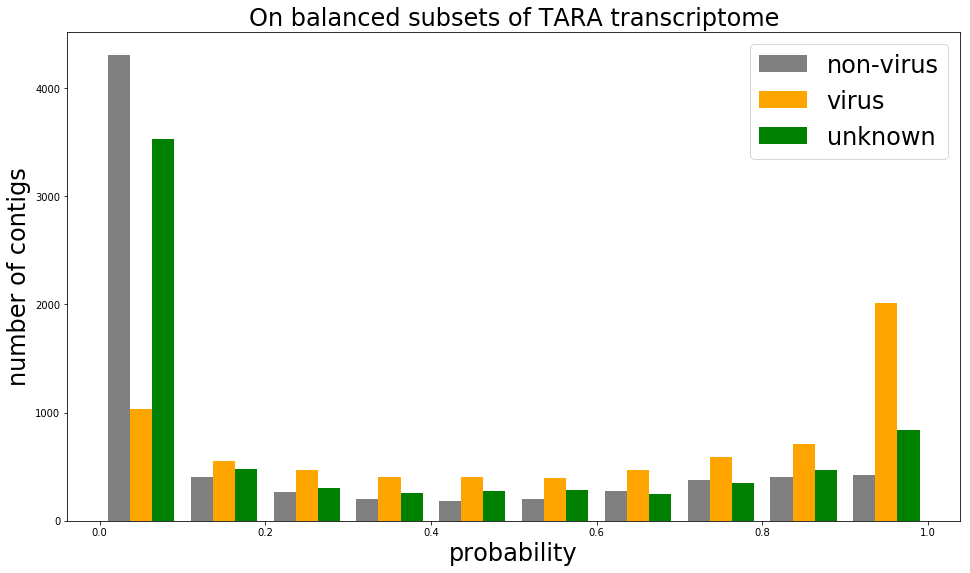

In [335]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.hybrid_probability,df_virus.hybrid_probability, df_unknown_subsample.hybrid_probability ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus','virus','unknown'],color=['grey', 'orange', 'green'])
ax0.set_title('On balanced subsets of TARA transcriptome',fontsize=24)
ax0.set_xlabel('probability',fontsize=24)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

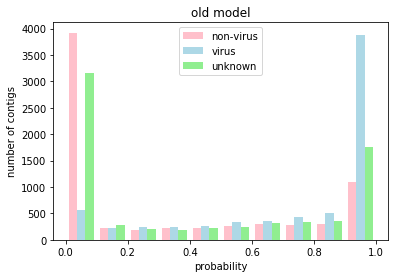

In [321]:
fig, axes = plt.subplots(nrows=1, ncols=1)
ax0 = axes
n_bins = 10

x_multi = [df_nonvirus_subsample.probability,df_virus.probability, df_unknown_subsample.probability ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus','virus','unknown'],color = ['pink', 'lightblue', 'lightgreen'])
ax0.set_title('old model')
ax0.set_xlabel('probability')
ax0.set_ylabel('number of contigs')
ax0.legend(prop={'size': 10})

In [156]:
balaced_virus_nonvirus = pd.concat([df_virus,df_nonvirus_subsample])
balaced_matrix_virus_nonvirus_hybrid = confusion_matrix(balaced_virus_nonvirus.label, balaced_virus_nonvirus.hybrid_prediction)
auprc_balaced_virus_nonvirus_hybrid = average_precision_score(balaced_virus_nonvirus.label, balaced_virus_nonvirus.hybrid_probability)
precision_balaced_virus_nonvirus_hybrid, recall_balaced_virus_nonvirus_hybrid, thresholds_balaced_virus_nonvirus_hybrid = precision_recall_curve(
    balaced_virus_nonvirus.label, balaced_virus_nonvirus.hybrid_probability)

balaced_matrix_virus_nonvirus_old = confusion_matrix(balaced_virus_nonvirus.label, balaced_virus_nonvirus.prediction)
auprc_balaced_virus_nonvirus_old = average_precision_score(balaced_virus_nonvirus.label, balaced_virus_nonvirus.probability)
precision_balaced_virus_nonvirus_old, recall_balaced_virus_nonvirus_old, thresholds_balaced_virus_nonvirus_old = precision_recall_curve(
    balaced_virus_nonvirus.label, balaced_virus_nonvirus.probability)


        

In [157]:
balaced_virus_nonvirus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,pred_virus_non_virus,hybrid_probability,hybrid_prediction,tax_id,rank,tax_name,top_label,non_euk_label,micromonas_label,annotation_label
1187,NODE_1190_length_4867_cov_31.1845_g863_i0,4867,0.003411,0.0,1.0,0.0,0.0,1.0,0.053115,0.0,...,0.0,0.013460,False,286,genus,Pseudomonas,Bacteria,True,False,with annotation
1385,NODE_1388_length_4479_cov_77.7475_g1017_i0,4479,0.995234,1.0,0.0,1.0,1.0,1.0,0.974094,1.0,...,0.0,0.984607,True,186616,no rank,environmental samples,Virus,True,False,with annotation
1698,NODE_1702_length_3955_cov_32.4023_g1269_i0,3955,0.094340,0.0,0.0,1.0,1.0,1.0,0.792640,1.0,...,0.0,0.273456,False,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1728,NODE_1732_length_3910_cov_62.4519_g1295_i0,3910,0.985221,1.0,0.0,1.0,1.0,1.0,0.960621,1.0,...,0.0,0.972844,True,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1748,NODE_1752_length_3882_cov_14.5733_g1313_i0,3882,0.355353,0.0,0.0,1.0,1.0,1.0,0.603147,1.0,...,0.0,0.462958,False,439488,no rank,ssRNA viruses,Virus,True,False,with annotation


In [162]:
balaced_matrix_virus_nonvirus_hybrid

array([[5361, 1680],
       [2865, 4176]])

In [163]:
balaced_matrix_virus_nonvirus_old

array([[4799, 2242],
       [1534, 5507]])

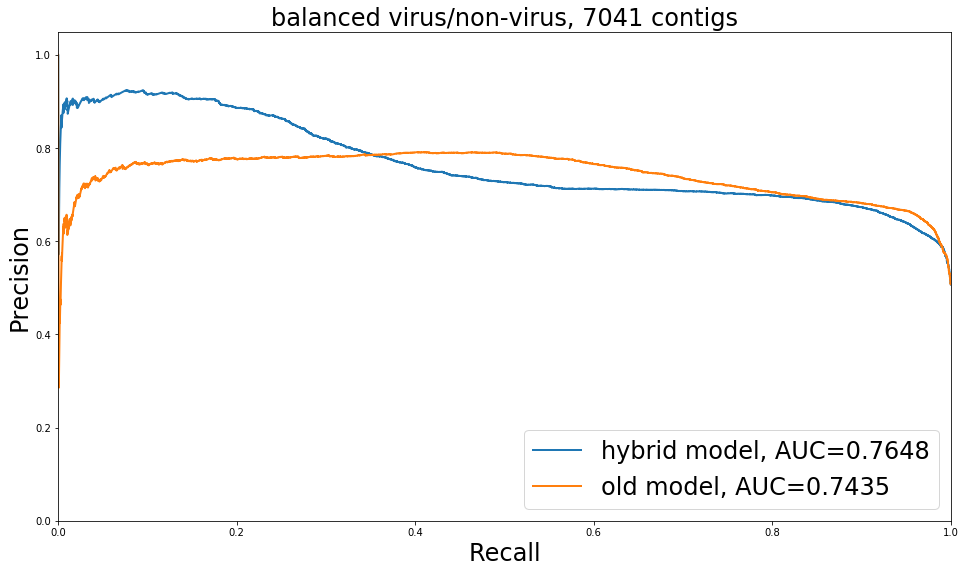

In [338]:
        lw = 2
        plt.figure(figsize=(16, 9), dpi=80)
        plt.clf()
        plt.plot(recall_balaced_virus_nonvirus_hybrid, precision_balaced_virus_nonvirus_hybrid, lw=lw, 
                 label='hybrid model, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_hybrid))
        plt.plot(recall_balaced_virus_nonvirus_old, precision_balaced_virus_nonvirus_old, lw=lw, 
                 label='old model, AUC={0:0.4f}'.format(auprc_balaced_virus_nonvirus_old))

        plt.xlabel('Recall',fontsize=24)
        plt.ylabel('Precision',fontsize=24)
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('balanced virus/non-virus, 7041 contigs',fontsize=24)
        plt.legend(loc="lower right",fontsize=24)



#### using all TARA contigs - imbalanced

In [164]:
df_virus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,pred_virus_non_virus,hybrid_probability,hybrid_prediction,tax_id,rank,tax_name,top_label,non_euk_label,micromonas_label,annotation_label
1187,NODE_1190_length_4867_cov_31.1845_g863_i0,4867,0.003411,0.0,1.0,0.0,0.0,1.0,0.053115,0.0,...,0.0,0.013460,False,286,genus,Pseudomonas,Bacteria,True,False,with annotation
1385,NODE_1388_length_4479_cov_77.7475_g1017_i0,4479,0.995234,1.0,0.0,1.0,1.0,1.0,0.974094,1.0,...,0.0,0.984607,True,186616,no rank,environmental samples,Virus,True,False,with annotation
1698,NODE_1702_length_3955_cov_32.4023_g1269_i0,3955,0.094340,0.0,0.0,1.0,1.0,1.0,0.792640,1.0,...,0.0,0.273456,False,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1728,NODE_1732_length_3910_cov_62.4519_g1295_i0,3910,0.985221,1.0,0.0,1.0,1.0,1.0,0.960621,1.0,...,0.0,0.972844,True,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1748,NODE_1752_length_3882_cov_14.5733_g1313_i0,3882,0.355353,0.0,0.0,1.0,1.0,1.0,0.603147,1.0,...,0.0,0.462958,False,439488,no rank,ssRNA viruses,Virus,True,False,with annotation


In [165]:

imbalaced_virus_nonvirus = pd.concat([df_virus,df_nonvirus])
imbalaced_matrix_virus_nonvirus_hybrid = confusion_matrix(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.hybrid_prediction)
auprc_imbalaced_virus_nonvirus_hybrid = average_precision_score(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.hybrid_probability)
precision_imbalaced_virus_nonvirus_hybrid, recall_imbalaced_virus_nonvirus_hybrid, thresholds_imbalaced_virus_nonvirus_hybrid = precision_recall_curve(
    imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.hybrid_probability)

imbalaced_matrix_virus_nonvirus_old = confusion_matrix(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.prediction)
auprc_imbalaced_virus_nonvirus_old = average_precision_score(imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.probability)
precision_imbalaced_virus_nonvirus_old, recall_imbalaced_virus_nonvirus_old, thresholds_imbalaced_virus_nonvirus_old = precision_recall_curve(
    imbalaced_virus_nonvirus.label, imbalaced_virus_nonvirus.probability)


        
    

In [166]:
imbalaced_virus_nonvirus.head()

,name,length,probability,prediction,vfam,pfam,diamond,label,score_euk_non_euk,pred_euk_non_euk,...,pred_virus_non_virus,hybrid_probability,hybrid_prediction,tax_id,rank,tax_name,top_label,non_euk_label,micromonas_label,annotation_label
1187,NODE_1190_length_4867_cov_31.1845_g863_i0,4867,0.003411,0.0,1.0,0.0,0.0,1.0,0.053115,0.0,...,0.0,0.013460,False,286,genus,Pseudomonas,Bacteria,True,False,with annotation
1385,NODE_1388_length_4479_cov_77.7475_g1017_i0,4479,0.995234,1.0,0.0,1.0,1.0,1.0,0.974094,1.0,...,0.0,0.984607,True,186616,no rank,environmental samples,Virus,True,False,with annotation
1698,NODE_1702_length_3955_cov_32.4023_g1269_i0,3955,0.094340,0.0,0.0,1.0,1.0,1.0,0.792640,1.0,...,0.0,0.273456,False,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1728,NODE_1732_length_3910_cov_62.4519_g1295_i0,3910,0.985221,1.0,0.0,1.0,1.0,1.0,0.960621,1.0,...,0.0,0.972844,True,196896,no rank,unclassified Myoviridae,Virus,True,False,with annotation
1748,NODE_1752_length_3882_cov_14.5733_g1313_i0,3882,0.355353,0.0,0.0,1.0,1.0,1.0,0.603147,1.0,...,0.0,0.462958,False,439488,no rank,ssRNA viruses,Virus,True,False,with annotation


In [167]:
imbalaced_matrix_virus_nonvirus_hybrid

array([[146072,  44951],
       [  2865,   4176]])

In [168]:
imbalaced_matrix_virus_nonvirus_old

array([[131866,  59157],
       [  1534,   5507]])

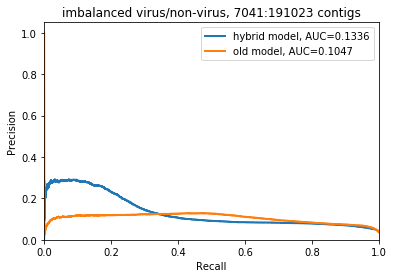

In [171]:
        lw = 2
        plt.figure(figsize=(6, 4), dpi=80)
        plt.clf()
        plt.plot(recall_imbalaced_virus_nonvirus_hybrid, precision_imbalaced_virus_nonvirus_hybrid, lw=lw, 
                 label='hybrid model, AUC={0:0.4f}'.format(auprc_imbalaced_virus_nonvirus_hybrid))
        plt.plot(recall_imbalaced_virus_nonvirus_old, precision_imbalaced_virus_nonvirus_old, lw=lw, 
                 label='old model, AUC={0:0.4f}'.format(auprc_imbalaced_virus_nonvirus_old))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('imbalanced virus/non-virus, 7041:191023 contigs')
        plt.legend(loc="upper right")


### Check the performance of the Euk/non-euk model

In [205]:
imbalaced_euk_noneuk = pd.concat([df_euk,df_noneuk])

In [206]:
balaced_euk_noneuk = pd.concat([df_euk,df_noneuk_subsample])

In [210]:
matrix_euk_non_euk_imbalanced = confusion_matrix(imbalaced_euk_noneuk.non_euk_label, imbalaced_euk_noneuk.pred_euk_non_euk)

In [211]:
matrix_euk_non_euk_imbalanced

array([[23114, 17806],
       [78591, 78232]])

In [212]:
matrix_euk_non_euk_balanced = confusion_matrix(balaced_euk_noneuk.non_euk_label, balaced_euk_noneuk.pred_euk_non_euk)

In [213]:
matrix_euk_non_euk_balanced

array([[23114, 17806],
       [20501, 20419]])

In [218]:
auprc_euk_imbalanced = average_precision_score(imbalaced_euk_noneuk.non_euk_label, imbalaced_euk_noneuk.score_euk_non_euk)

In [214]:
auprc_euk_balanced = average_precision_score(balaced_euk_noneuk.non_euk_label, balaced_euk_noneuk.score_euk_non_euk)

In [215]:
auprc_euk_balanced

0.49098866035330868

In [179]:
auprc_euk_balanced

0.89867674729120406

In [219]:
precision_euk_imbalanced, recall_euk_imbalanced, thresholds_euk_imbalanced = precision_recall_curve(imbalaced_euk_noneuk.non_euk_label, imbalaced_euk_noneuk.score_euk_non_euk)

In [216]:
precision_euk_balanced, recall_euk_balanced, thresholds_euk_balanced = precision_recall_curve(balaced_euk_noneuk.non_euk_label, balaced_euk_noneuk.score_euk_non_euk)

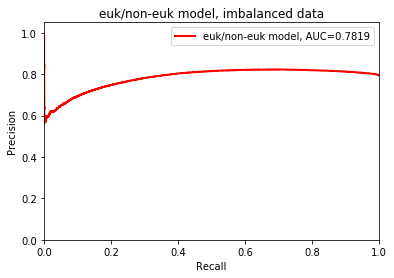

In [221]:
        lw = 2
        plt.figure(figsize=(6, 4), dpi=80)
        plt.clf()
        plt.plot(recall_euk_imbalanced, precision_euk_imbalanced, lw=lw, color='red',
                 label='euk/non-euk model, AUC={0:0.4f}'.format(auprc_euk_imbalanced))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('euk/non-euk model, imbalanced data')
        plt.legend(loc="upper right")



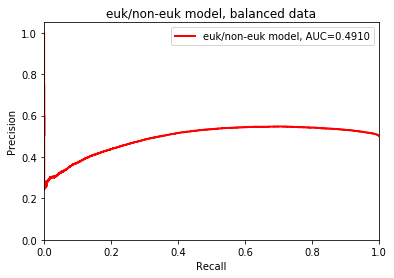

In [222]:
        lw = 2
        plt.figure(figsize=(6, 4), dpi=80)
        plt.clf()
        plt.plot(recall_euk_balanced, precision_euk_balanced, lw=lw, color='red',
                 label='euk/non-euk model, AUC={0:0.4f}'.format(auprc_euk_balanced))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('euk/non-euk model, balanced data')
        plt.legend(loc="upper right")



#### Euk/non-Euk itself does not perform very well using the MEGA annotation as ground truth

#### it's still possible, the euk/non-euk works for some family......

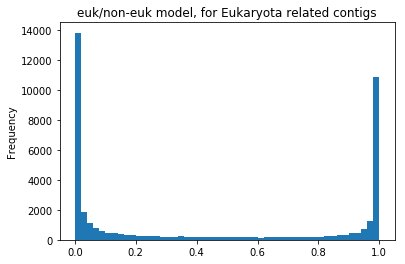

In [285]:
new_table[new_table.top_label=='Eukaryota'].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for Eukaryota related contigs')

/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


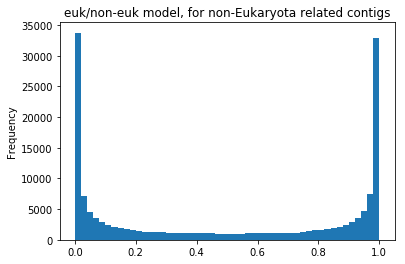

In [286]:
new_table[new_table.top_label!='Eukaryota'][new_table.annotation_label=='with annotation'].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for non-Eukaryota related contigs')

#### This means removing low euk/non-euk score contigs, will not remove many real virus

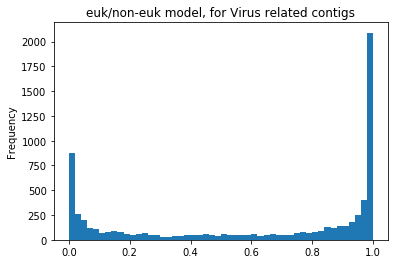

In [287]:
new_table[new_table.label==1].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for Virus related contigs')

/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


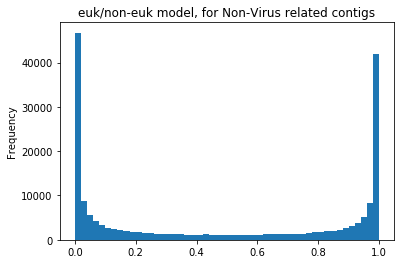

In [288]:
new_table[new_table.label==0][new_table.annotation_label=='with annotation'].score_euk_non_euk.plot.hist(bins=50, title='euk/non-euk model, for Non-Virus related contigs')

In [230]:
len(new_table[new_table.probability>=0.9])

34939

In [231]:
len(new_table[new_table.probability>=0.9][new_table.label==1.0])

/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


3882

In [232]:
len(new_table[new_table.probability>=0.9][new_table.label==0.0])

/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


31057

In [233]:
len(new_table[new_table.probability<=0.1])

111998

In [234]:
len(new_table[new_table.probability<=0.1][new_table.label==1.0])

/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


558

In [235]:
len(new_table[new_table.probability<=0.1][new_table.label==0.0])

/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


111440

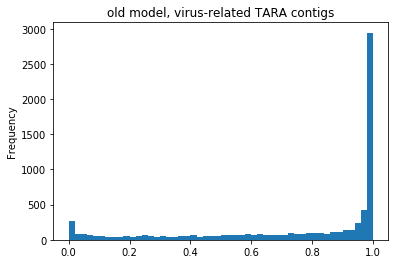

In [236]:
new_table[new_table.label==1.0].probability.plot.hist(bins=50, title = 'old model, virus-related TARA contigs')

/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


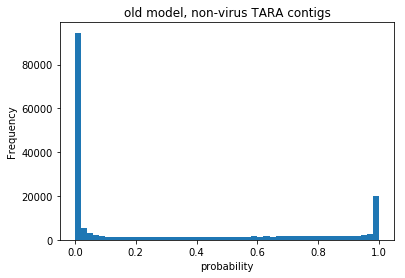

In [281]:
ax = new_table[new_table.label==0.0][new_table.annotation_label=='with annotation'].probability.plot.hist(bins=50, title = 'old model, non-virus TARA contigs')
ax.set_xlabel("probability")

/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


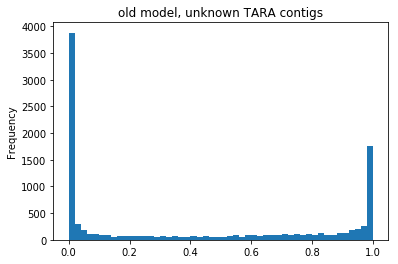

In [241]:
new_table[new_table.label==0.0][new_table.annotation_label!='with annotation'].probability.plot.hist(bins=50, title = 'old model, unknown TARA contigs')

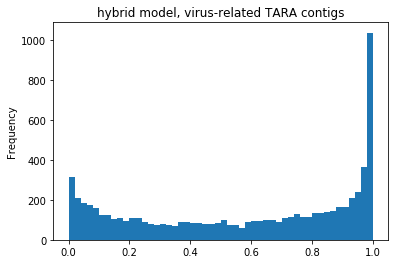

In [242]:
new_table[new_table.label==1.0].hybrid_probability.plot.hist(bins=50, title = 'hybrid model, virus-related TARA contigs')

/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


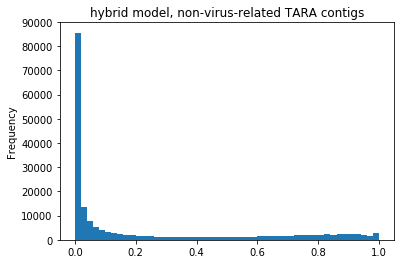

In [244]:
new_table[new_table.label==0.0][new_table.annotation_label=='with annotation'].hybrid_probability.plot.hist(bins=50, title = 'hybrid model, non-virus-related TARA contigs')

/global/u2/q/qpzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


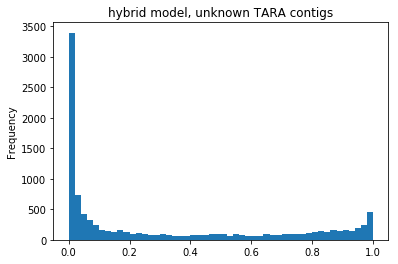

In [282]:
new_table[new_table.label==0.0][new_table.annotation_label!='with annotation'].hybrid_probability.plot.hist(bins=50, title = 'hybrid model, unknown TARA contigs')

### Check the micromous -related contigs

#### most of micromonas contigs has lower euk/non-euk score, prone to be euk....

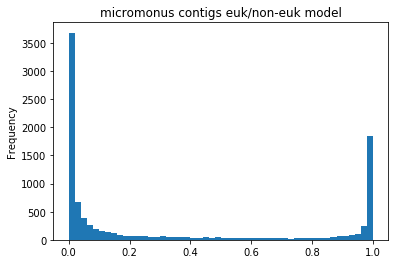

In [289]:
df_micromonus.score_euk_non_euk.plot.hist(bins=50, title = 'micromonus contigs euk/non-euk model')

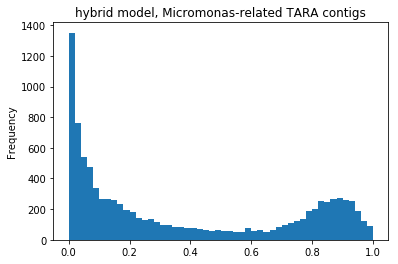

In [250]:
df_micromonus.hybrid_probability.plot.hist(bins=50, title = 'hybrid model, Micromonas-related TARA contigs')

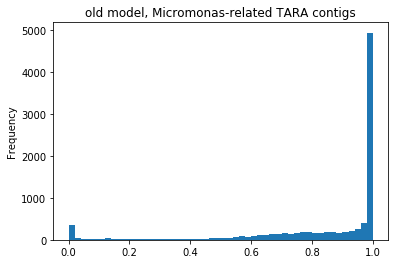

In [251]:
df_micromonus.probability.plot.hist(bins=50, title = 'old model, Micromonas-related TARA contigs')

In [ ]:
sub_table = new_table.loc[:,['probability','hybrid_probability','label','tax_id','rank','tax_name']]

In [ ]:
sub_table.head()

In [ ]:
grouped = sub_table.groupby(['label'])

In [264]:
import pandas

In [262]:
grouped_category = new_table.groupby('category')

In [269]:
boxplot_data_old = [new_table[new_table.category=='virus'].probability,new_table[new_table.category=='nonvirus'].probability,
               new_table[new_table.category=='unknown'].probability]

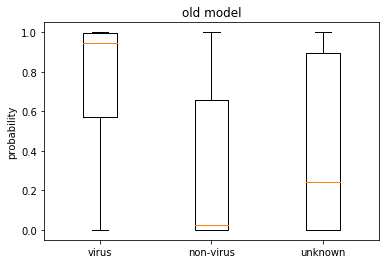

In [291]:
plt.figure()
label_list = ['virus','non-virus','unknown']
plt.boxplot(boxplot_data_old,labels = label_list)
plt.title('old model')
plt.ylabel('probability')
plt.show()

In [271]:
boxplot_data_hybrid = [new_table[new_table.category=='virus'].hybrid_probability,new_table[new_table.category=='nonvirus'].hybrid_probability,
               new_table[new_table.category=='unknown'].hybrid_probability]

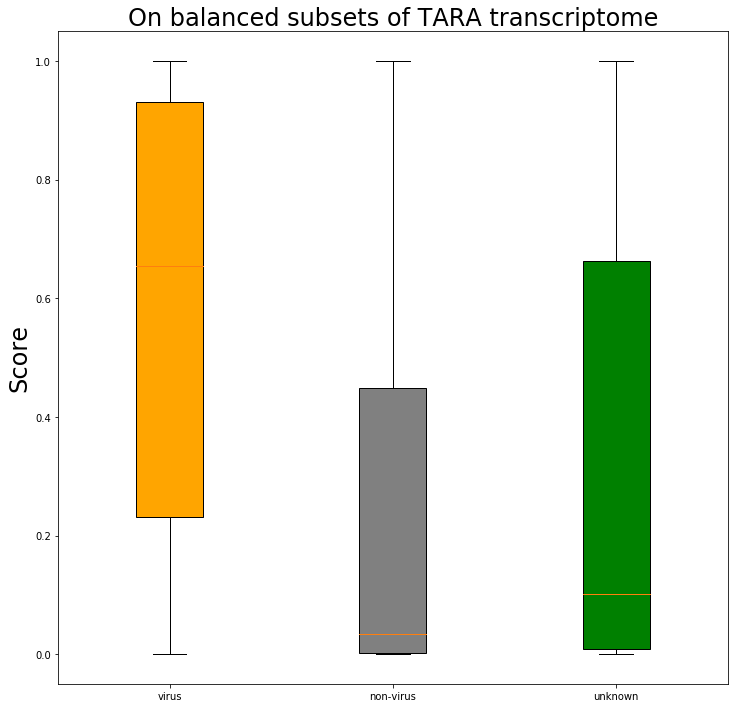

In [337]:
colors = ['orange', 'grey', 'green']



fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

label_list = ['virus','non-virus','unknown']
bplot1 = ax0.boxplot(boxplot_data_hybrid,labels = label_list,patch_artist=True)
ax0.set_title('On balanced subsets of TARA transcriptome',fontsize=24)
ax0.set_ylabel('Score',fontsize=24)



for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

In [ ]:
predict_nonvirus = sub_table.groupby(['label']).get_group(0.0)

In [ ]:
predict_nonvirus.head()

In [ ]:
predict_nonvirus[predict_nonvirus.probability>0.99].describe()

In [ ]:
grouped = predict_nonvirus.loc[:,['probability','hybrid_probability','rank']].groupby(['rank'])

In [ ]:
predict_nonvirus_rank = predict_nonvirus.loc[:,['probability','hybrid_probability','rank']]

In [ ]:
def convert_rank(rank):
    if rank == 'no rank':
        return 'no rank'
    else:
        return 'rank'
    

In [ ]:
predict_nonvirus_rank['no_rank'] = predict_nonvirus_rank['rank'].map(convert_rank)

In [ ]:
predict_nonvirus_rank.head()

In [ ]:
predict_nonvirus_rank_subset = predict_nonvirus_rank[(predict_nonvirus_rank['rank'] =='class') | (predict_nonvirus_rank['rank'] =='family') | (predict_nonvirus_rank['rank'] =='genus')\
                      | (predict_nonvirus_rank['rank'] =='kingdom')| (predict_nonvirus_rank['rank'] =='no rank')| (predict_nonvirus_rank['rank'] =='order')\
                      | (predict_nonvirus_rank['rank'] =='phylum')| (predict_nonvirus_rank['rank'] =='species')| (predict_nonvirus_rank['rank'] =='superkingdom')]


In [ ]:
predict_nonvirus_rank_grouped = predict_nonvirus_rank.groupby(['no_rank'])

In [ ]:
predict_nonvirus_rank_grouped.describe()

In [ ]:
predict_nonvirus_rank_grouped.boxplot(column=['hybrid_probability'])

In [ ]:
predict_nonvirus_rank_grouped.boxplot(column=['probability'])

In [ ]:
9169.0/111440

In [ ]:
tax_name_count_99 = predict_nonvirus[predict_nonvirus.probability>0.99].groupby('tax_name').size().reset_index()

In [ ]:
tax_name_count_99['percent_99'] = tax_name_count_99[0].apply(lambda x: 100*x/float(tax_name_count_99.sum()))

In [ ]:
tax_name_count_99.head()

In [ ]:
tax_name_count_01 = predict_nonvirus[predict_nonvirus.probability<0.01].groupby('tax_name').size().reset_index()

In [ ]:
tax_name_count_01['percent_01'] = tax_name_count_01[0].apply(lambda x: 100*x/float(tax_name_count_01.sum()))

In [ ]:
tax_name_count_01.head()


In [ ]:
tax_name = pd.merge(tax_name_count_99,tax_name_count_01,how='inner',on=['tax_name'])

In [ ]:
tax_name.head()

In [ ]:
tax_name['increase'] = tax_name.apply(lambda x:x['percent_99']/x['percent_01'], axis=1)

In [ ]:
tax_name.sort_values(by='increase')

In [ ]:
tax_name.sort_values(by='percent_99')

In [ ]:
1587.0/31057

In [ ]:
predict_nonvirus[predict_nonvirus.probability>0.9].groupby('tax_id').size()

In [ ]:
predict_nonvirus[predict_nonvirus.probability>0.9].groupby('rank').size()

In [ ]:
predict_nonvirus[predict_nonvirus.probability<0.1].groupby('rank').size()

In [ ]:
predict_virus = sub_table.groupby(['label']).get_group(1.0)

In [ ]:
result = pd.read_csv('/Users/qingpeng/shred.fa.score',sep=' ',header=None,names=['probability','prediction'])

In [ ]:
result

In [ ]:
result.probability.plot.hist(bins=100)